In [1]:
# Packages
import pandas as pd
import Qu_v1 as prepr
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

In [2]:
# Import Data
data = pd.read_csv("train.csv", sep=",")

In [3]:
# Check
print('Total Data ' + str(len(data)))
print('Total Insincere Questions : '+ str(data.target.sum()))
print('% Insincere Questions : '+ str(round(data.target.sum()*100/len(data),2)))
print(data.columns)

Total Data 1306122
Total Insincere Questions : 80810
% Insincere Questions : 6.19
Index(['qid', 'question_text', 'target'], dtype='object')


In [4]:
import Qu_v1 as msai
clean_sent = msai.text_clean()

In [5]:
data.loc[:,'qtok'] = data.loc[:,'question_text'].apply(lambda x : nltk.word_tokenize(x))
data.loc[:,'qtok'] = data.loc[:,'qtok'].apply(lambda x : clean_sent.special_char_removal(x))
data.loc[:,'qtok'] = data.loc[:,'qtok'].apply(lambda x : clean_sent.punctuation_trimming(x))
data.loc[:,'qtok'] = data.loc[:,'qtok'].apply(lambda x : clean_sent.conv_to_lower(x))
data.loc[:, 'qclean'] = data.loc[:,'qtok'].apply(lambda x : ' '.join(x))
data.loc[:,'q_len'] = data.loc[:,'qtok'].apply(lambda x : len(x))

In [7]:
# Sample

smp = 90000 # Sample number for insincere questions

data_is = data[data.target == 1].reset_index(drop=True)
data_s = data[data.target == 0].reset_index(drop=True)
data_s = data_s.sample(smp).reset_index(drop=True)
sample = pd.concat([data_is,data_s],axis=0).reset_index(drop=True)

In [8]:
sample = sample[sample.q_len >= 3].reset_index(drop=True)

In [7]:
### TF IDF Score
def get_tfidf(data):    
    tfv = TfidfVectorizer(stop_words='english', lowercase=True,ngram_range=(1,2),min_df=0.001,smooth_idf=True)
    corpus = list(data.question_text)
    X = tfv.fit_transform(corpus)
    feature_names = tfv.get_feature_names()
    corpus_index = [n for n in corpus]
    df = pd.DataFrame(X.todense(), columns=feature_names, index=corpus_index)
    imp = pd.DataFrame(df.apply(np.mean))
    imp.loc[:,'word'] = imp.index
    imp.columns = ['score','word']
    return imp

In [8]:
tf_ins = get_tfidf(data_is) # Insincere questions
tf_s = get_tfidf(data_s) # Sincere questions

In [ ]:
def wcloud_freq(tf_data):
    d = {}
    for i in range(len(imp)):
        d[imp.word[i]] = imp.score[i]
    wordcloud = WordCloud(background_color="white")
    wordcloud.generate_from_frequencies(frequencies=d)
    plt.figure( figsize=(8,4) )
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


In [ ]:
wcloud_freq(tf_ins)

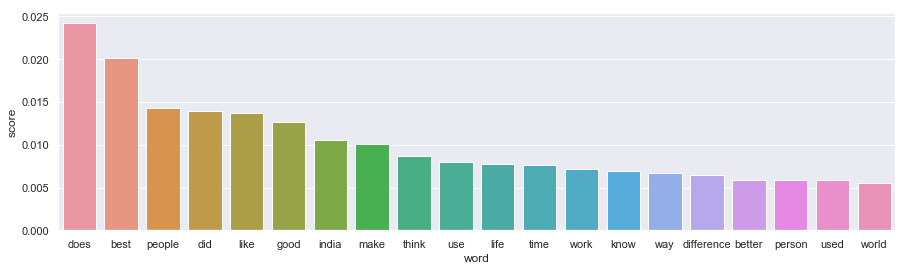

In [9]:
# tfidf plot for Sincere questions

sns.set(style="darkgrid")
plt.figure( figsize=(15,4) )
sns.barplot(x="word", y="score", data=tf_s.sort_values(by="score",ascending=False).head(20))

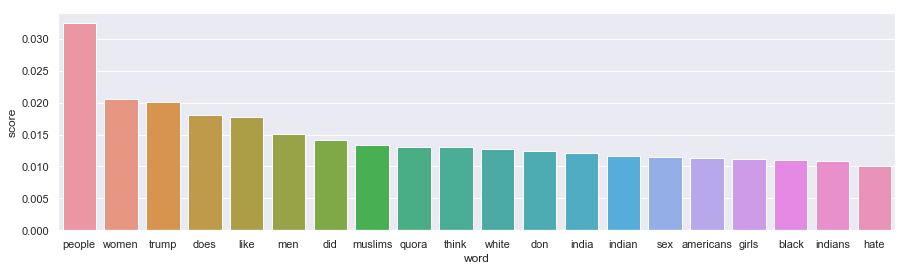

In [10]:
# tfidf plot for Insincere questions

sns.set(style="darkgrid")
plt.figure( figsize=(15,4) )
sns.barplot(x="word", y="score", data=tf_ins.sort_values(by="score",ascending=False).head(20))

In [16]:
import spacy
en_nlp = spacy.load('C:/Users/suvajit/Anaconda3/lib/site-packages/en_core_web_sm/en_core_web_sm-2.0.0')

In [25]:
def ner(x):
    tagged=[]
    document=en_nlp(x)
    for element in document.ents:
        tagged.append((element.label_))
    return tagged

In [26]:
sample['noun_tags'] = sample['qclean'].apply(lambda x: ner(x))
nt1 = sum(list(sample[sample.target==1]['noun_tags']),[])
nt2 = sum(list(sample[sample.target==0]['noun_tags']),[])

np.unique(nt1, return_counts=True)
np.unique(nt2, return_counts=True)

KeyboardInterrupt: 

In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

C:\Users\suvajit\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [20]:
# Create Sentiment scores using Vader

sid = SentimentIntensityAnalyzer()
sample['si'] = sample['qclean'].apply(lambda x : sid.polarity_scores(x)['compound'])

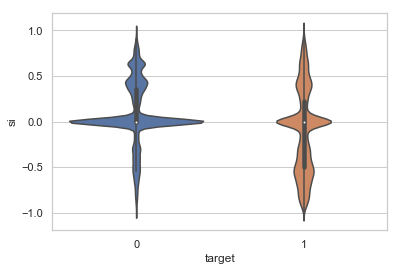

In [21]:
sns.set(style="whitegrid")
ax = sns.violinplot(x="target",y="si",data=sample)

In [22]:
print("% Neg SI for Insincere questions " + str(len(sample[(sample.target == 1) & (sample.si < 0)])/len(sample[sample.target==1])))
print("% Neg SI for Sincere questions " + str(len(sample[(sample.target == 0) & (sample.si < 0)])/len(sample[sample.target==0])))
print("% Pos SI for Insincere questions " + str(len(sample[(sample.target == 1) & (sample.si > 0 )])/len(sample[sample.target==1])))
print("% Pos SI for Sincere questions " + str(len(sample[(sample.target == 0) & (sample.si > 0)])/len(sample[sample.target==0])))

% Neg SI for Insincere questions 0.4532731097636431
% Neg SI for Sincere questions 0.17527777777777778
% Pos SI for Insincere questions 0.3091944066328425
% Pos SI for Sincere questions 0.35325555555555554


In [23]:
a = en_nlp(sample['qclean'][5])

In [24]:
sample['qclean'][5]

'why do females find penises ugly'

In [ ]:
sample['parsed'] = sample.question_text.apply(en_nlp)    

In [ ]:
def get_subob(parsed_txt):
    #subject would be
    if text.dep_ == "nsubj":
        subject = text.orth_
    #iobj for indirect object
    if text.dep_ == "iobj":
        indirect_object = text.orth_
    #dobj for direct object
    if text.dep_ == "dobj":
        direct_object = text.orth_

In [ ]:
def root_word(en_doc):
    sent_list = list(en_doc.sents)
    sent = sent_list[0]
    for token in sent:
        if token.dep_ == "ROOT":
            root_token = token.tag_
            root = token.text
    return root,root_token

In [ ]:
root_word(a)

In [ ]:
def get_embeddings(x):
    embeddings=[]
    for i in x:
        if i in gv:
            embeddings.append(gv[i])
    return embeddings

In [ ]:
glove_embeddings={}
emb_dim=300
global glove_embeddings,emb_dim
file=open("glove.840B.300d/glove.840B.300d.txt","r", encoding='utf-8',errors='ignore')

In [ ]:
def load_glove_model(f):
    model = {}
    vector_size = 300
    for line in f:
        split_line = line.split()
        word = " ".join(split_line[0:len(split_line) - vector_size])
        embedding = np.array([float(val) for val in split_line[-vector_size:]])
        model[word] = embedding
    print("Done.\n" + str(len(model)) + " words loaded!")
    return model

In [ ]:
gv = load_glove_model(file)

In [ ]:
get_embeddings(['the'])

In [ ]:
### LSTM